In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit as lm

In [2]:
egfp = pd.read_excel("data-siRNA/2017_06_02_seq6_Huh7_controll_#molecules.xlsx",sheet="#GFP_corrected").dropna()

In [3]:
egfp_data = egfp.values.T

In [4]:
egfp_data.shape

(443, 150)

In [5]:
time = egfp_data[0].astype(np.double)
egfp_data = egfp_data[1:].astype(np.double)

Text(0,0.5,'# if GFP molecules')

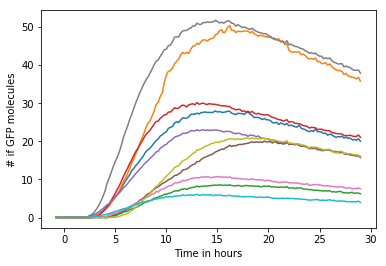

In [6]:
for data in egfp_data[:10]:
    plt.plot(time,data)
plt.xlabel("Time in hours")
plt.ylabel("# if GFP molecules")

In [7]:
def egfp_expression(t,ktm,delta,beta,t0):
    result = ktm/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))
    result[t<t0]=0
    return result

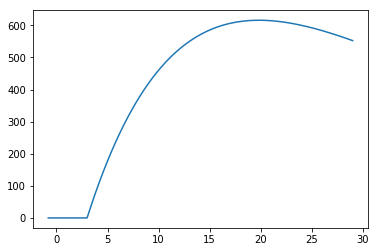

In [8]:
plt.plot(time,egfp_expression(time,100,0.05,0.07,3))

In [9]:
egfp_mod = lm.Model(egfp_expression)

In [10]:
data = egfp_data[10]
sigma = np.sqrt(np.abs(data))
sigma[sigma<=0]=1.0

[[Model]]
    Model(egfp_expression)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 150
    # variables        = 4
    chi-square         = 66.3569383
    reduced chi-square = 0.45449958
    Akaike info crit   = -114.338045
    Bayesian info crit = -102.295504
[[Variables]]
    ktm:    4.02329903 +/- 0.05788146 (1.44%) (init = 3)
    delta:  0.08407842 +/- 6.24766796 (7430.76%) (init = 0.03)
    beta:   0.08409964 +/- 6.24878767 (7430.22%) (init = 0.05)
    t0:     4.50557734 +/- 0.06100699 (1.35%) (init = 6)
[[Correlations]] (unreported correlations are < 0.100)
    C(delta, beta) = -1.000
    C(ktm, t0)     =  0.641
    C(ktm, beta)   =  0.183
    C(ktm, delta)  = -0.183



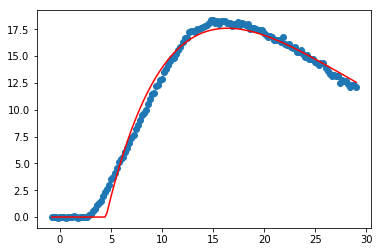

In [11]:
pars = egfp_mod.make_params()
pars['ktm'].set(value=3,vary=True,min=0)
pars['delta'].set(value=0.03,vary=True,min=0)
pars['beta'].set(value=0.05,vary=True,min=0)
pars['t0'].set(value=6,vary=True,min=0)

#result0 = egfp_mod.fit(data,pars,t=time,method='nelder')

#print(result0.fit_report())

#plt.plot(time,data,"o")
#plt.plot(time, result0.best_fit, 'r-')

result = egfp_mod.fit(data,pars,t=time,method='leastsq')

print(result.fit_report())

plt.plot(time,data,"o")
plt.plot(time, result.best_fit, 'r-')


In [12]:
def chisqTwoStage(t,data,delta,beta,t0,ktm):
    time = t-t0
    middle = 1 - np.exp(-((delta-beta)*time[:,np.newaxis,np.newaxis]))
    last = np.exp(-beta*time[:,np.newaxis,np.newaxis])
    first = ktm/(delta-beta)
    y = first*middle*last
    res = (data - y.T).T
    return np.sum(res**2,axis=0)

In [13]:
# let us plot the two-dimensional chi^2 distribution
beta = np.linspace(0.06,0.1,101)
delta = np.linspace(0.06,.1,101)

B,D = np.meshgrid(beta,delta)
#print(M.shape)
Z = chisqTwoStage(time,data,D,B,result.values['t0'],result.values['ktm'])

zz = Z.reshape(101*101)
zz = zz[~np.isnan(zz)]

print(np.mean(zz),np.min(zz),np.max(zz))

#plt.contour(B, D, Z)
#plt.colorbar()

8997.101025076003 8453.796861923734 12230.269504117572


/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/hstrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


In [14]:
#plt.contour(B, D, Z,np.min(zz)+np.logspace(-3,4,20))
#plt.colorbar()